In [2115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from scipy import optimize
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
array_shape = (4,4)
telescope_number = np.prod(array_shape)
telescope_array = np.arange(telescope_number).reshape(array_shape)
tele_pos = [np.array(np.unravel_index(i, array_shape)) for i in range(telescope_number)]

In [4]:
def get_baseline_key(i1, i2, shape=array_shape):
    p1 = np.array(np.unravel_index(i1, shape))
    p2 = np.array(np.unravel_index(i2, shape))
    pos_diff = p1 - p2
    sign = np.product(pos_diff)
    if sign > 0:
        key = tuple(np.abs(pos_diff))
    else:
        key = tuple((np.abs(pos_diff[0]), -1*np.abs(pos_diff[1])))
    return key

In [5]:
def get_num_baselines(tele_num=telescope_number):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*tele_num - 2*np.sqrt(tele_num)
    return int(N_bases)

In [6]:
def get_baselines_np(tele_num=telescope_number):
    base_size = get_num_baselines(tele_num)
#     redundant_baselines = sparse.dok_matrix((base_size, tele_num, tele_num))
    redundant_baselines = np.zeros((base_size, tele_num, tele_num))
    baseline_indx = []
    for i in range(tele_num):
        for k in range(tele_num):
            if i==k:
                continue
            key = get_baseline_key(i,k)
            if key in baseline_indx:
                red_indx = baseline_indx.index(key)
                redundant_baselines[red_indx][i,k] = 1
            else:
                baseline_indx.append(key)
                redundant_baselines[len(baseline_indx)-1][i,k] = 1
    return redundant_baselines, baseline_indx

In [7]:
redundant_baselines, baseline_indx = get_baselines_np()
n_bases = get_num_baselines(telescope_number)

In [8]:
def get_baseline_indx(i1, i2, base_idx = baseline_indx):
    key = get_baseline_key(i1, i2)
    return base_idx.index(key)

In [9]:
rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)

In [10]:
npcb = np.vectorize(pow)

In [2562]:
def make_gains(tele_num=telescope_number):
#     gain_amp = np.abs(np.random.normal(1, .3, tele_num))
    gain_amp = np.ones(tele_num)
    gain_phase = rand_phases(tele_num)
    tgain = gain_amp*np.exp(1j*gain_phase)
    return tgain, gain_phase

In [2563]:
def make_visibilities(tele_num=telescope_number):
    n_bases = get_num_baselines(telescope_number)
    sky_phase = rand_phases(n_bases)
    correl_sky = np.random.normal(3, .8, n_bases)*np.exp(1j*sky_phase)
    return correl_sky, sky_phase

In [2692]:
def make_uv_points(tg, va, tele_num=telescope_number, noise_amp=.01, noise_sig=.005):
    observation_baselines = np.zeros((tele_num, tele_num), dtype=np.complex128)
    unsym_noise = np.random.normal(noise_amp, noise_sig, (tele_num, tele_num)) + 1j*np.random.normal(noise_amp, noise_sig, (tele_num, tele_num))
    noise_matrix = (unsym_noise + np.conj(unsym_noise).T)*.5
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            key = get_baseline_key(i, k)
            red_indx = baseline_indx.index(key)
            if i < k:
                vaterm = va[red_indx]
            else:
                vaterm = np.conj(va[red_indx])
            noise = noise_matrix[i,k]
            signal = tg[i]*np.conj(tg[k])*vaterm
            observation_baselines[i,k] = signal+noise
    return observation_baselines, noise_matrix

In [2693]:
tgain, gain_phase = make_gains()
valpha, v_phase = make_visibilities()

In [2694]:
observation_baselines, noises = make_uv_points(tgain, valpha)

In [2567]:
snr = np.mean(np.abs(valpha)/np.mean(np.abs(noises)))
print("SNR is %f" % snr)

SNR is 426.330879


In [2762]:
def omnical(iter_max, obs, g0, v0, sigma, delta=.4, epsilon=1e-5):
    y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
    w_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)+16
    chisqr = []
    garr = g0.copy()
    varr = v0.copy()
    y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
    
    for n in range(iter_max):
        
    #     gprime = garr*npcb(((w_ij*observation_baselines)/y_ij).sum(axis=1)/(w_ij.sum(axis=1)), 1/3)
        gdiv = np.divide(w_ij*obs, y_ij, out=np.zeros_like(w_ij), where=(y_ij!=0))
        gprime = garr * gdiv.sum(axis=1)/(w_ij.sum(axis=1))
        garr = (1 - delta)*garr + delta*gprime

        vprime = np.zeros(n_bases, dtype=np.complex128)
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            numer = ((w_ij[indxs]*obs[indxs])/y_ij[indxs]).sum()
            denom = (w_ij[indxs]).sum()
            vprime[i] = varr[i]*numer/denom
        varr = (1-delta)*varr + delta*vprime

        gscale = 1/np.mean(np.abs(garr))
#         gscale = 1
        vscale = (1/gscale)**2
        garr = garr*gscale
        varr = varr*vscale

        y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
#         chisqr.append((np.abs(obs-y_ij)**2).sum())
        chiscore = np.triu((np.abs(y_ij - observation_baselines)**2)/(np.abs(sigma))).sum()
        chisqr.append(chiscore)
        if n > 20:
            if np.abs((chisqr[-1] - chisqr[-2])) < epsilon:
                break
    return garr, varr, chisqr, n

In [2763]:
def chimincal(iter_max, obs, g0, v0, sigma, delta=.4, epsilon=1e-5):
    y_ij = np.zeros((telescope_number, telescope_number), dtype=np.complex128)
    score = []
    chisqr = []
    garr = g0.copy()
    varr = v0.copy()
    N = 1
    
    for n in range(iter_max):    
        vprime = np.zeros(n_bases, dtype=np.complex128)
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            clean_l = []
            clean_k = []
            for l,k in zip(*indxs):
                if l < k:
                    clean_l.append(l)
                    clean_k.append(k)
            new_indx = (clean_l, clean_k)
            numer = (obs[new_indx]).sum()
            denom = (garr[clean_l]*np.conj(garr[clean_k])).sum()
            vprime[i] = numer/denom - varr[i]
            
        varr += vprime
        
        
        gprime = np.zeros(telescope_number, dtype=np.complex128)
        numer = np.zeros_like(gprime)
        denom = np.zeros_like(gprime)
        for i in range(telescope_number):
            for k in range(telescope_number):
                if i==k:
                    continue
                else:
                    v_indx = get_baseline_indx(i,k)
                    if i < k:
                        vterm = varr[v_indx]
                    else:
                        vterm = np.conj(varr[v_indx])
                    g2 = np.conj(garr[k])
                    numer[i] += obs[i,k]*np.conj(g2)*np.conj(vterm)
                    denom[i] += np.abs(g2*vterm)**2

            gprime[i] = numer[i]/denom[i] - garr[i]
            
        garr += gprime   
        gscale = N/np.median(np.abs(garr))
        garr *= gscale
        varr *= (1/gscale)**2

        
        y_ij, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
        
        #         chisqr.append((np.abs(obs-y_ij)**2).sum())
        
        chiscore = np.triu((np.abs(y_ij - observation_baselines)**2)/(np.abs(sigma))).sum()
        chisqr.append(chiscore)
        if n > 20:
            if np.abs(chisqr[-1] - chisqr[-2]) < epsilon:
                break
        
    return garr, varr, chisqr, n

In [2764]:
def compare(true_gain, true_va, reps, noise_a=.01, noise_s=.005, **kwargs):
    tgain = true_gain.copy()
    tvalp = true_va.copy()
    # Set up variables to fill in during the runs

    omni_gains = np.zeros((reps, len(tgain)), dtype=np.complex128)
    chi_gains = np.zeros_like(omni_gains)
    omni_chi_gains = np.zeros_like(omni_gains)
    omni_avg_gain = np.zeros_like(omni_gains)
    chi_avg_gain = np.zeros_like(omni_avg_gain)
    
    omni_valp = np.zeros((reps, len(tvalp)), dtype=np.complex128)
    chi_valp = np.zeros_like(omni_valp)
    omni_chi_valp = np.zeros_like(omni_valp)
    omni_avg_valp = np.zeros_like(omni_valp)
    chi_avg_valp = np.zeros_like(omni_valp)
    omni_chis = []
    chi_chis = []
    guess_chis = []
    fin_n = np.zeros((reps, 2))
    
    n_sigma = np.zeros((telescope_number, telescope_number))+(noise_s**2/2 + noise_s**2/2*1j)

    for n in tqdm(range(reps)):
        # Generate observed data
        uv_points, _ = make_uv_points(tgain, tvalp, noise_amp=noise_a, noise_sig=noise_s)
        # Set up guesses
        
        vguess = np.zeros(n_bases, dtype=np.complex128)
        for i in range(n_bases):
            indxs = np.where(redundant_baselines[i]==1)
            clean_l = []
            clean_k = []
            for l,k in zip(*indxs):
                if l < k:
                    clean_l.append(l)
                    clean_k.append(k)
            new_indx = (clean_l, clean_k)
            vguess[i] = np.mean(uv_points[new_indx])
            
        gguess = tgain*np.exp(1j*np.random.uniform(-np.pi/12, np.pi/12, telescope_number))
        guess_uv, _ = make_uv_points(gguess, vguess, noise_amp=0, noise_sig=0)
        guess_chis.append((np.abs(uv_points - guess_uv)**2).sum())

        # Solve with different methods
        gomni, vomni, omnichi, omnin = omnical(obs=uv_points, g0=gguess, v0=vguess, sigma=n_sigma, **kwargs)
        gchi, vchi, chichi, chin = chimincal(obs=uv_points, g0=gguess, v0=vguess, sigma=n_sigma, **kwargs)
        # Put results in the right place
        omni_avg_gain[n] = gomni
        omni_avg_valp[n] = vomni
        
        chi_avg_gain[n] = gchi
        chi_avg_valp[n] = vchi
        
        omni_gains[n] = gomni - tgain
        chi_gains[n] = gchi - tgain
        omni_chi_gains[n] = gomni - gchi
        
        omni_valp[n] = vomni - tvalp
        chi_valp[n] = vchi - tvalp
        omni_chi_valp[n] = vomni - vchi
        
        omni_chis.append(omnichi)
        chi_chis.append(chichi)
        
        fin_n[n] = (omnin, chin)
    
    fomni_avg_gain = np.median(omni_avg_gain, axis=0)
    fomni_avg_valp = np.median(omni_avg_valp, axis=0)
    fchi_avg_gain = np.median(chi_avg_gain, axis=0)
    fchi_avg_valp = np.median(chi_avg_valp, axis=0)
    
    return omni_gains, chi_gains, omni_chi_gains, omni_valp, chi_valp, omni_chi_valp, omni_chis, chi_chis, guess_chis, fin_n, fomni_avg_gain, fomni_avg_valp, fchi_avg_gain, fchi_avg_valp

In [2765]:
compare_dict = {"iter_max": 400, "delta": .2, "epsilon": 1e-5}

In [2766]:
trials = compare(tgain, valpha, 3, **compare_dict)

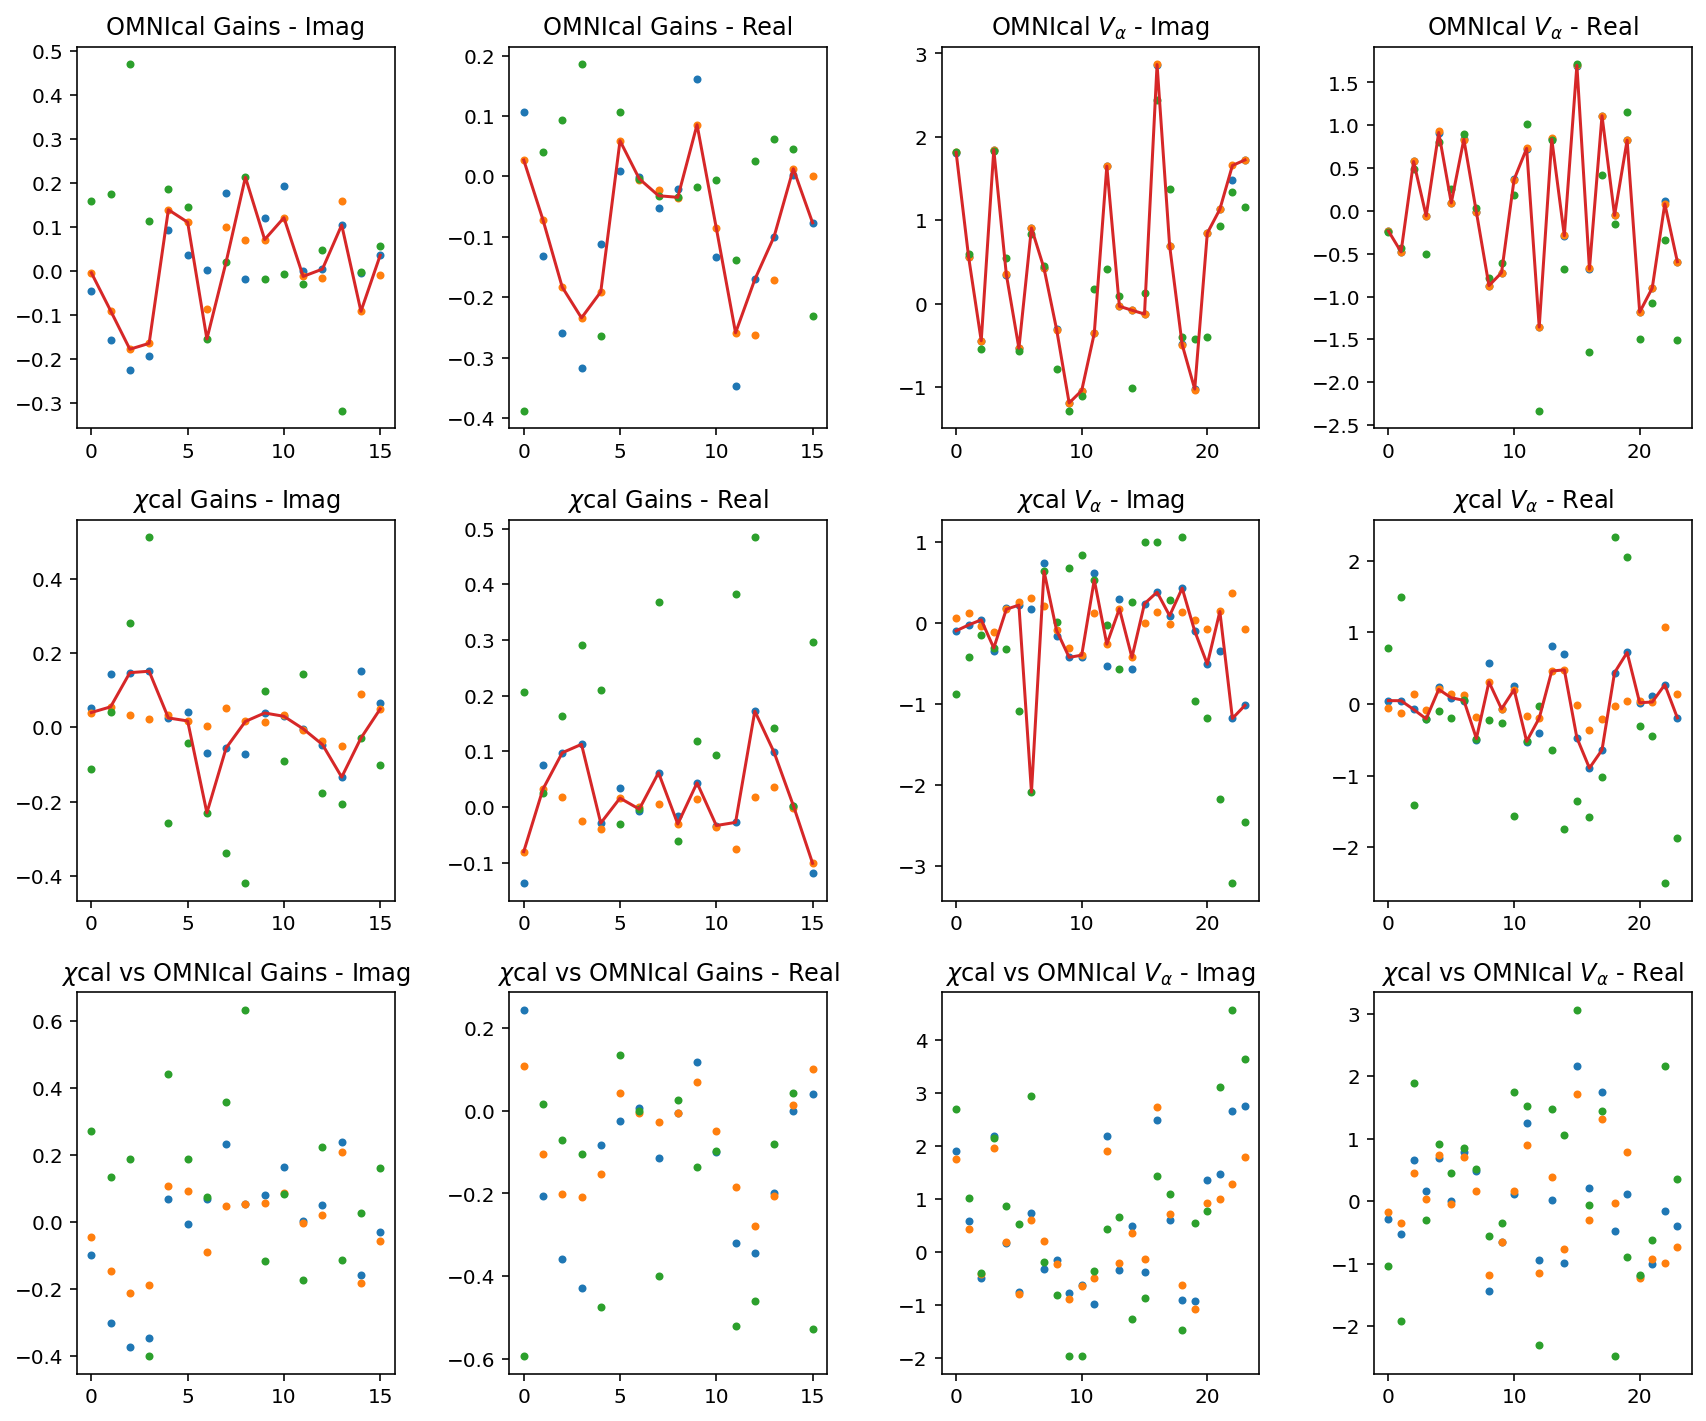

In [2767]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,10))
iflambda = lambda x : np.max(np.abs(x)) < 20 and True

for i in trials[0].imag:
    if iflambda(i):
        axes[0,0].plot(i, '.')
axes[0,0].plot((trials[-4] - tgain).imag)
axes[0,0].set_title("OMNIcal Gains - Imag")

for i in trials[0].real:
    if iflambda(i):
        axes[0,1].plot(i, '.')
axes[0,1].plot((trials[-4] - tgain).real)
axes[0,1].set_title("OMNIcal Gains - Real")

for i in trials[3].imag:
    if iflambda(i):
        axes[0,2].plot(i, '.')
axes[0,2].plot((trials[-3] - valpha).imag)
axes[0,2].set_title(r"OMNIcal $V_\alpha$ - Imag")

for i in trials[3].real:
    if iflambda(i):
        axes[0,3].plot(i, '.')
axes[0,3].plot((trials[-3] - valpha).real)
axes[0,3].set_title(r"OMNIcal $V_\alpha$ - Real")

for i in trials[1].imag:
    if iflambda(i):
        axes[1,0].plot(i, '.')
axes[1,0].plot((trials[-2] - tgain).imag)
axes[1,0].set_title(r"$\chi$cal Gains - Imag")

for i in trials[1].real:
    if iflambda(i):
        axes[1,1].plot(i, '.')
axes[1,1].plot((trials[-2] - tgain).real)
axes[1,1].set_title(r"$\chi$cal Gains - Real")

for i in trials[4].imag:
    if iflambda(i):
        axes[1,2].plot(i, '.')
axes[1,2].plot((trials[-1] - valpha).imag)
axes[1,2].set_title(r"$\chi$cal $V_\alpha$ - Imag")

for i in trials[4].real:
    if iflambda(i):
        axes[1,3].plot(i, '.')
axes[1,3].plot((trials[-1] - valpha).real)
axes[1,3].set_title(r"$\chi$cal $V_\alpha$ - Real")

for i in trials[2].imag:
    if iflambda(i):
        axes[2,0].plot(i, '.')
axes[2,0].set_title(r"$\chi$cal vs OMNIcal Gains - Imag")

for i in trials[2].real:
    if iflambda(i):
        axes[2,1].plot(i, '.')
axes[2,1].set_title(r"$\chi$cal vs OMNIcal Gains - Real")

for i in trials[5].imag:
    if iflambda(i):
        axes[2,2].plot(i, '.')
axes[2,2].set_title(r"$\chi$cal vs OMNIcal $V_\alpha$ - Imag")

for i in trials[5].real:
    if iflambda(i):
        axes[2,3].plot(i, '.')
axes[2,3].set_title(r"$\chi$cal vs OMNIcal $V_\alpha$ - Real")



plt.tight_layout()

In [2775]:
degree_of_freedoms = (16*15) - 2*(n_bases + telescope_number)

In [2776]:
degree_of_freedoms

160

In [2777]:
omni_chis, chi_chis, start_chi = trials[6], trials[7], trials[8]

In [2778]:
init_omni_chis = [np.abs(chis[0]) for chis in omni_chis]
init_chi_chis = [np.abs(chis[0]) for chis in chi_chis]
last_omni_chis = [chis[-1] for chis in omni_chis]
last_chi_chis = [chis[-1] for chis in chi_chis]

In [2779]:
# last_omni_chis.pop(last_omni_chis.index(max(last_omni_chis)));
# last_chi_chis.pop(last_chi_chis.index(max(last_chi_chis)));

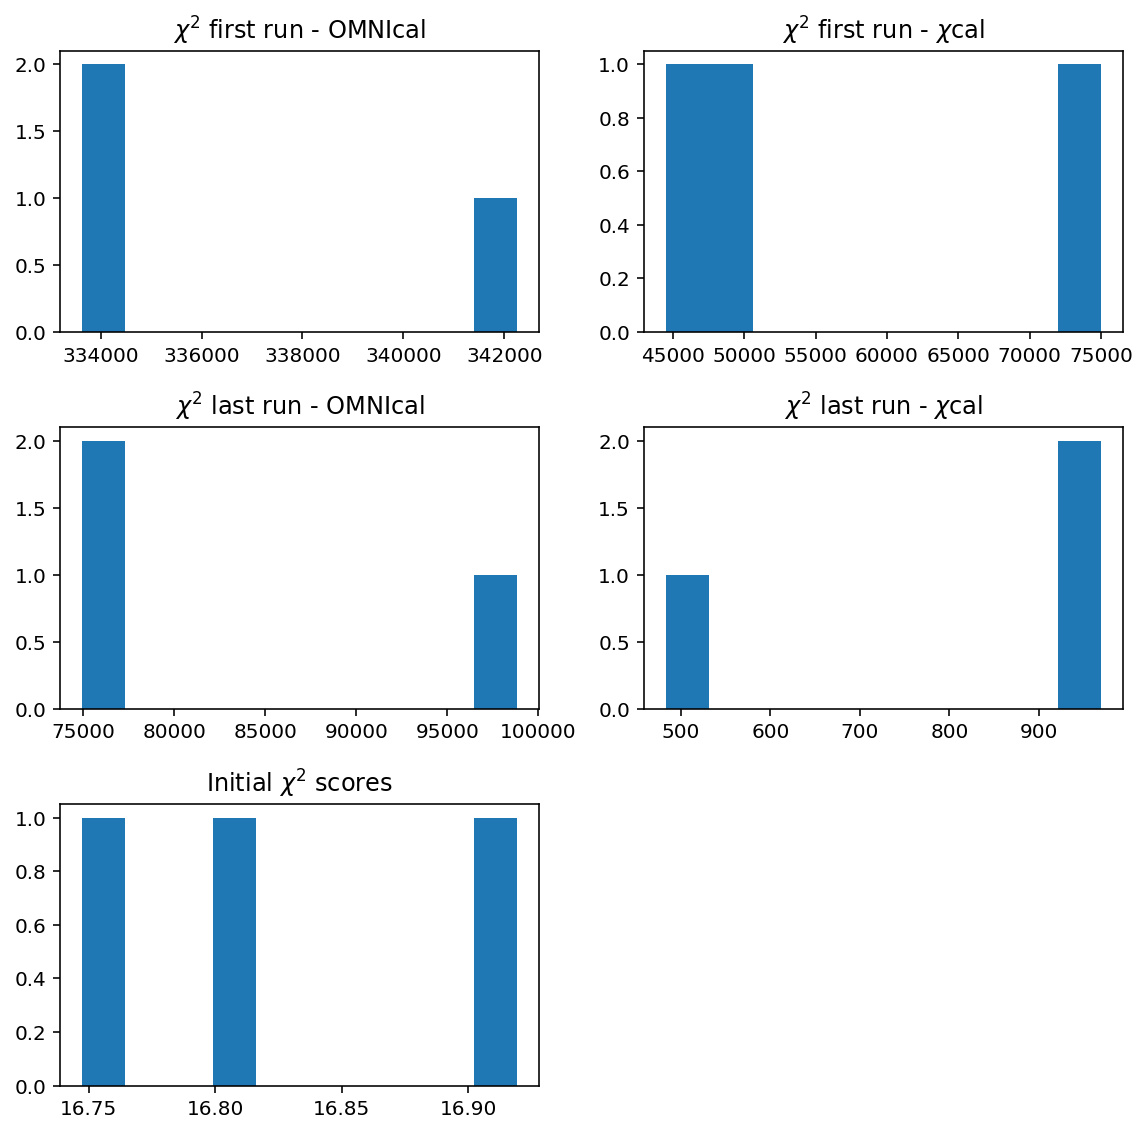

In [2780]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))

axes[0,0].hist(init_omni_chis/degree_of_freedoms)
axes[0,0].set_title(r"$\chi^2$ first run - OMNIcal")

axes[0,1].hist(init_chi_chis/degree_of_freedoms)
axes[0,1].set_title(r"$\chi^2$ first run - $\chi$cal")

axes[1,0].hist(last_omni_chis/degree_of_freedoms)
axes[1,0].set_title(r"$\chi^2$ last run - OMNIcal")

axes[1,1].hist(last_chi_chis/degree_of_freedoms)
axes[1,1].set_title(r"$\chi^2$ last run - $\chi$cal")

axes[2,0].hist(start_chi/degree_of_freedoms)
axes[2,0].set_title(r"Initial $\chi^2$ scores")
axes[2,1].remove()
 
plt.tight_layout()

In [2781]:
np.var(trials[2].real, axis=0)

array([1.34637530e-01, 8.33849390e-03, 1.38141989e-02, 1.82130745e-02,
       2.88563964e-02, 4.32892798e-03, 2.46235139e-05, 2.52706949e-02,
       2.25034815e-04, 1.20969851e-02, 5.58450141e-04, 1.91779927e-02,
       5.58657612e-03, 3.36922812e-03, 3.18486791e-04, 8.02300847e-02])

In [1899]:
iter_max = 400
delta = .4
eps = 1e-5

# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
# g0 = 1*np.exp(1j*rand_phases(telescope_number))
# g0 = 1*np.exp(1j*gain_phase)
# g0 = tgain.copy() + gain_perturb
g0 = np.ones(telescope_number, dtype=np.complex128)
# v0 = 3*np.exp(1j*rand_phases(n_bases))
v0 = valpha.copy()

In [1900]:
gomni, vomni, omnichi, omnin = omnical(iter_max, g0, v0, delta, eps)
gchi, vchi, chichi, chin = chimincal(iter_max, g0, v0, delta, eps)

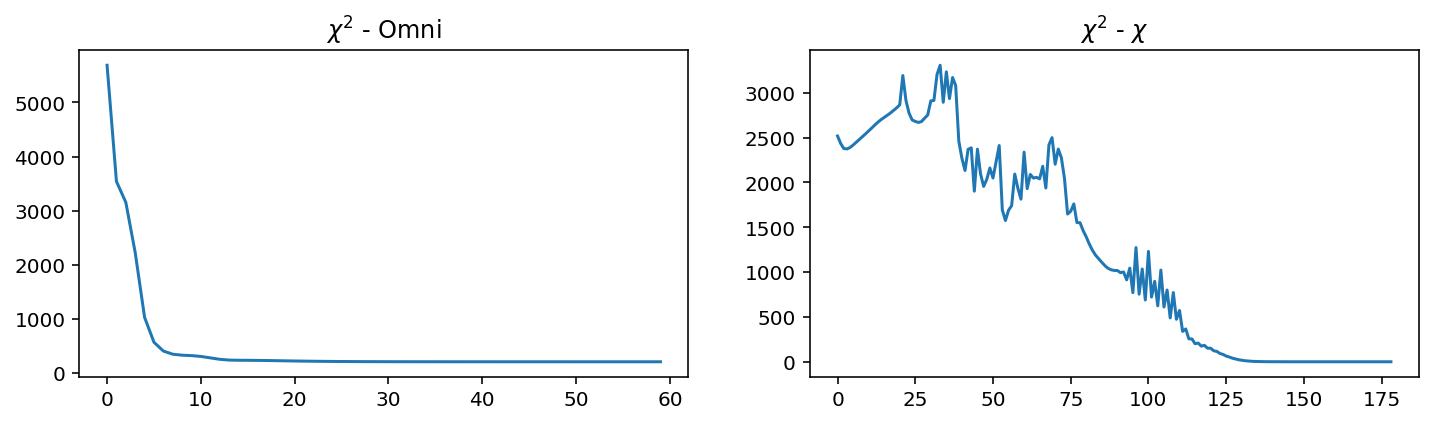

In [1901]:
fig, axes = plt.subplots(ncols=2, figsize=(12,3))

axes[0].plot(omnichi[:omnin])
axes[0].set_title(r"$\chi^2$ - Omni")

axes[1].plot(chichi[:chin])
axes[1].set_title(r"$\chi^2$ - $\chi$");

In [1902]:
title_mod = r"g=1+0i"

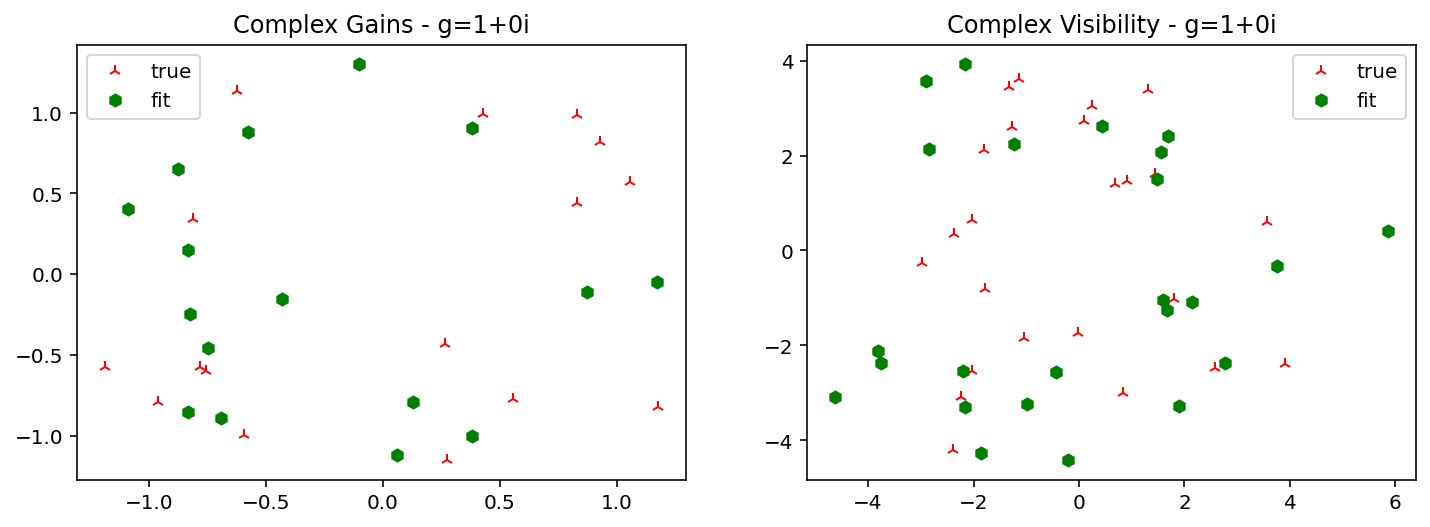

In [1903]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(gchi.real, gchi.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(vchi.real, vchi.imag, 'gh', label='fit')
axes[1].legend();

In [50]:
# fig, axes = plt.subplots(ncols=2, figsize=(12,4))

# axes[0].set_title('Complex Gains - %s' % title_mod)
# axes[0].plot(tgain.real, 'r.', label='true')
# axes[0].plot(tgain.imag, 'b.', label='true')
# axes[0].plot(garr.real, 'rx', label='fit')
# axes[0].plot(garr.imag, 'bx', label='fit')
# axes[0].legend();

# axes[1].set_title('Complex Visibility - %s' % title_mod)
# axes[1].plot(valpha.real, 'r.', label='true')
# axes[1].plot(valpha.imag, 'b.', label='true')
# axes[1].plot(varr.real, 'rx', label='fit')
# axes[1].plot(varr.imag, 'bx', label='fit')
# axes[1].legend();

In [1862]:
iter_max = 500
delta=.4
epsilon=1e-5
# g0 = 1*np.exp(1j*(gain_phase + (np.random.random(16)*2-1)/10))
# g0 = 1*np.exp(1j*rand_phases(telescope_number))
g0 = 1*np.exp(1j*gain_phase)
# g0 = tgain.copy()
# g0 = np.ones(telescope_number, dtype=np.complex128)
# v0 = 3*np.exp(1j*rand_phases(n_bases))
v0 = valpha.copy()

In [2194]:
uv_points, _ = make_uv_points(tgain, valpha, noise_amp=.01, noise_sig=.005)
vguess = np.zeros(n_bases, dtype=np.complex128)
for i in range(n_bases):
    indxs = np.where(redundant_baselines[i]==1)
    clean_l = []
    clean_k = []
    for l,k in zip(*indxs):
        if l < k:
            clean_l.append(l)
            clean_k.append(k)
    new_indx = (clean_l, clean_k)
    vguess[i] = np.mean(uv_points[new_indx])

gguess = 1*np.exp(1j*rand_phases(telescope_number))

In [2043]:
garr, varr, chisqr, finiters = chimincal(iter_max, gguess, vguess, delta, epsilon)
# garr, varr = simplechical(100, g0, v0)

In [2044]:
garr

array([ 0.44949528+0.99901376j, -0.59530116-0.87061657j,
       -0.52209671-0.63715484j, -0.79700123-0.64363071j,
        1.09462853-0.12770261j, -0.45192838+0.80439081j,
        0.66461855+0.35227115j,  0.31170172-0.94133326j,
        0.96826912+0.28165552j, -0.68056198-1.01879511j,
        0.66400981+0.4661481j , -0.6387256 +0.84957322j,
       -0.80961725+0.1732828j ,  0.13759522+0.40878323j,
       -1.00557865+0.49958276j, -0.71667623+0.34883199j])

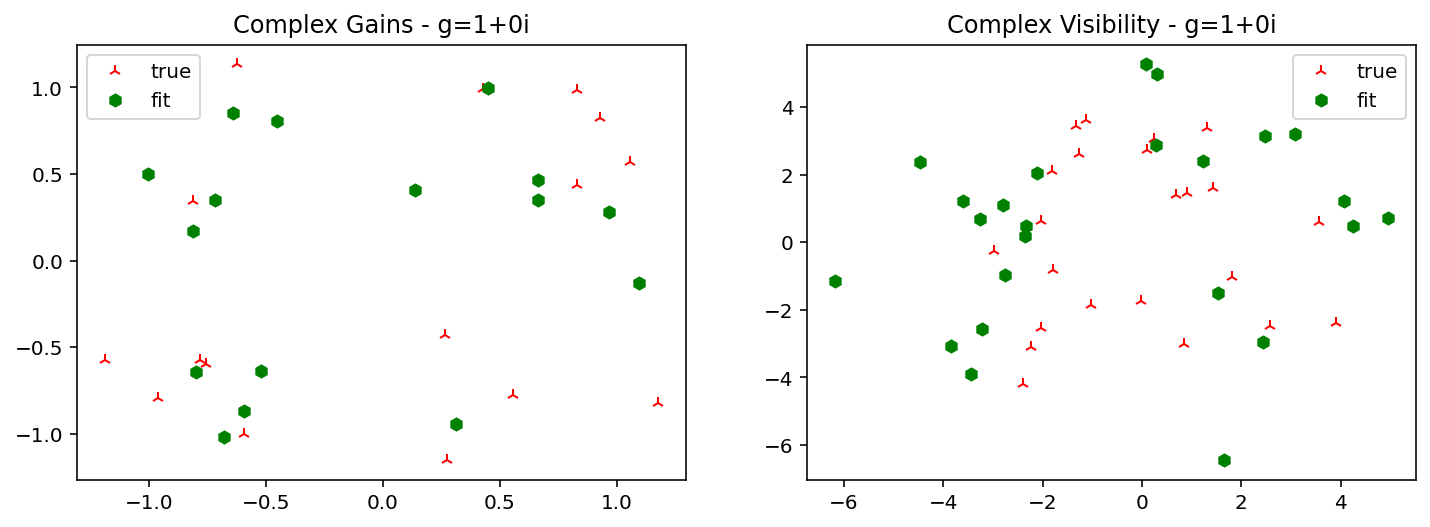

In [2045]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(garr.real, garr.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(varr.real, varr.imag, 'gh', label='fit')
axes[1].legend();

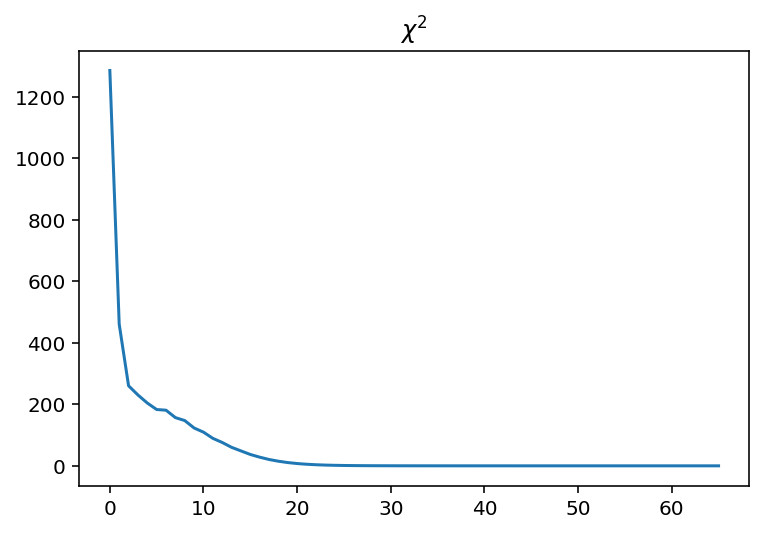

In [1861]:
plt.plot(chisqr[:finiters])
plt.title(r"$\chi^2$");

In [2125]:
def chifunc_ls(zs):
    garr = zs[0:telescope_number]
    varr = zs[telescope_number:]
    value, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
    return np.linalg.norm(observation_baselines - value)

In [2160]:
l0 = list(l[0])
l1 = list(l[1])

In [2229]:
def make_jac(x):
    gains_off = 2*telescope_number
    garr = x[:telescope_number] + 1j*x[telescope_number:gains_off]
    varr = x[gains_off:gains_off+n_bases] + 1j*x[gains_off+n_bases:]
    jac_vec = np.zeros(len(x), dtype=np.complex128)
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                if i < k:
                    vterm = varr[v_indx]
                else:
                    vterm = np.conj(varr[v_indx])
                g2 = np.conj(garr[k])
            jac_term = np.conj(garr[i])*np.abs(g2*vterm)**2 - g2*vterm*np.conj(observation_baselines[i,k])
            jac_vec[i] += jac_term
            jac_vec[i+telescope_number] += 1j*jac_term
    for l in range(gains_off, gains_off+n_bases):
        i = l - gains_off
        indxs = np.where(redundant_baselines[i]==1)
        clean_1 = []
        clean_2 = []
        for m,n in zip(*indxs):
            if m < n:
                clean_1.append(m)
                clean_2.append(n)
        new_indx = (clean_1, clean_2)
        jac_term = np.sum(np.abs(garr[clean_1] * garr[clean_2])**2*np.conj(varr[i]) - garr[clean_1]*np.conj(garr[clean_2])*np.conj(observation_baselines[clean_1, clean_2]))
        jac_vec[l] = jac_term
        jac_vec[l+n_bases] = 1j*jac_term
    return jac_vec

In [2170]:
def lsquare_tonormal(x):
    gains_off = 2*telescope_number
    garr = x[:telescope_number] + 1j*x[telescope_number:gains_off]
    varr = x[gains_off:gains_off+n_bases] + 1j*x[gains_off+n_bases:]
    return garr, varr

In [2171]:
def chiwrapper(x):
    garr, varr = lsquare_tonormal(x)
    return chifunc_ls(np.concatenate((garr, varr)))

In [2206]:
gguess = tgain*np.exp(1j*np.random.uniform(-np.pi/6, np.pi/6, telescope_number))

In [2213]:
xguess = np.concatenate((gguess.real, gguess.imag, vguess.real, vguess.imag))

In [2214]:
xscale = np.concatenate((np.abs(gguess), np.abs(gguess), np.abs(vguess), np.abs(vguess)))

In [2226]:
lmfit = optimize.least_squares(chiwrapper, xguess, jac=make_jac, verbose=2, max_nfev=100, x_scale=xscale)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3927e+03                                    9.03e+03    
       1             16         2.3927e+03      0.00e+00       0.00e+00       9.03e+03    
`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 2.3927e+03, final cost 2.3927e+03, first-order optimality 9.03e+03.


In [2227]:
garr, varr = lsquare_tonormal(lmfit.x)

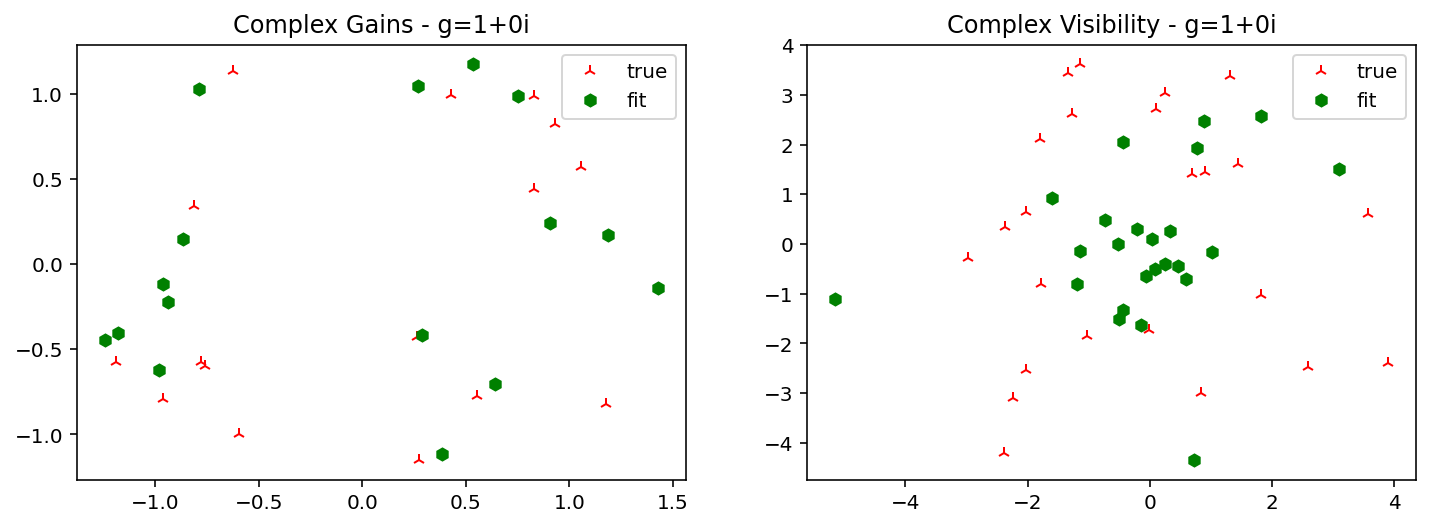

In [2228]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

axes[0].set_title('Complex Gains - %s' % title_mod)
axes[0].plot(tgain.real, tgain.imag, 'r2', label='true')
axes[0].plot(garr.real, garr.imag, 'gh', label='fit')
axes[0].legend();

axes[1].set_title('Complex Visibility - %s' % title_mod)
axes[1].plot(valpha.real, valpha.imag, 'r2', label='true')
axes[1].plot(varr.real, varr.imag, 'gh', label='fit')
axes[1].legend();

In [2231]:
def graddescent_ls(zs):
    garr = zs[0:telescope_number]
    varr = zs[telescope_number:]
    value, _ = make_uv_points(garr, varr, noise_amp=0, noise_sig=0)
    return np.linalg.norm(observation_baselines - value)

In [2236]:
def grad_jac(x):
    garr = x[:telescope_number]
    varr = x[telescope_number:]
    jac_vec = np.zeros(telescope_number + n_bases, dtype=np.complex128)
    for i in range(telescope_number):
        for k in range(telescope_number):
            if i==k:
                continue
            else:
                v_indx = get_baseline_indx(i,k)
                if i < k:
                    vterm = varr[v_indx]
                else:
                    vterm = np.conj(varr[v_indx])
                g2 = np.conj(garr[k])
            jac_term = np.conj(garr[i])*np.abs(g2*vterm)**2 - g2*vterm*np.conj(observation_baselines[i,k])
            jac_vec[i] += jac_term
    for l in range(telescope_number, telescope_number+n_bases):
        i = l - telescope_number
        indxs = np.where(redundant_baselines[i]==1)
        clean_1 = []
        clean_2 = []
        for m,n in zip(*indxs):
            if m < n:
                clean_1.append(m)
                clean_2.append(n)
        new_indx = (clean_1, clean_2)
        jac_term = np.sum(np.abs(garr[clean_1] * garr[clean_2])**2*np.conj(varr[i]) - garr[clean_1]*np.conj(garr[clean_2])*np.conj(observation_baselines[clean_1, clean_2]))
        jac_vec[l] = jac_term
    return jac_vec

In [2263]:
grad_guess = np.concatenate((gguess, vguess))

In [2265]:
graddescent_ls(grad_guess)

69.17613827782468

In [2274]:
gnew = grad_guess

In [2275]:
gnew -= .1*grad_jac(grad_guess)

In [2276]:
graddescent_ls(gnew)

6019912239756.458

In [2266]:
def simple_grad_descent(x, reps, delstep=.2):
    cost = np.zeros(reps, dtype=np.complex128)
    iterx = x.copy()
    for n in range(reps):
        grad = grad_jac(iterx)
        iterx -= delstep*grad
        cost[n] = graddescent_ls(iterx)
    return iterx, cost

In [2267]:
finx, cost = simple_grad_descent(grad_guess, 10, .1)

<ipython-input-2236-bf5e44f36641>:16: RuntimeWarning: overflow encountered in double_scalars
  jac_term = np.conj(garr[i])*np.abs(g2*vterm)**2 - g2*vterm*np.conj(observation_baselines[i,k])
<ipython-input-2236-bf5e44f36641>:28: RuntimeWarning: overflow encountered in square
  jac_term = np.sum(np.abs(garr[clean_1] * garr[clean_2])**2*np.conj(varr[i]) - garr[clean_1]*np.conj(garr[clean_2])*np.conj(observation_baselines[clean_1, clean_2]))
<ipython-input-2266-2f0a4a9af675>:6: RuntimeWarning: invalid value encountered in multiply
  iterx -= delstep*grad


In [2268]:
cost

array([2.72316489e+03+0.j, 6.01413939e+12+0.j, 6.41587313e+59+0.j,
                  inf+0.j,            nan+0.j,            nan+0.j,
                  nan+0.j,            nan+0.j,            nan+0.j,
                  nan+0.j])